In [1]:
# importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime

import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
from keras import Model
from keras.models import Model
from keras.models import load_model, save_model
from keras.layers import Dense, Dropout, Flatten, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, TensorBoard
from keras.metrics import AUC, Precision, Recall
from keras.applications import DenseNet121

from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.utils import class_weight

import os

from utils import *

%reload_ext autoreload
%autoreload 2


In [2]:
# defining parameters
IMAGE_SIZE = 224
BATCH_SIZE = 32
INIT_LR = 0.001
EPOCHS = 20

## Set up the file directory and image paths

In [3]:
# Set path for training testing and validation
# Data Generator for training, validation, and testing

folder = '../data/augmented_sorted'

# assigning paths
src_path_train = os.path.join(folder, 'train/')
src_path_val = os.path.join(folder, "val/")
src_path_test = os.path.join(folder,  'test/')

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        src_path_train,
        target_size = (IMAGE_SIZE, IMAGE_SIZE),
        batch_size = BATCH_SIZE,
        class_mode = 'binary',
        shuffle = True,
        seed = 42)
valid_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        src_path_val,
        target_size = (IMAGE_SIZE, IMAGE_SIZE),
        batch_size = BATCH_SIZE,
        class_mode = 'binary',
        shuffle = True,
        seed = 42)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        src_path_test,
        target_size = (IMAGE_SIZE, IMAGE_SIZE),
        batch_size = 1,
        class_mode = None,
        shuffle = False,
        seed = 42)

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

Found 10134 images belonging to 2 classes.
Found 1031 images belonging to 2 classes.
Found 1035 images belonging to 2 classes.


In [4]:
# calculate class weights
total_tb = len(os.listdir(os.path.join(src_path_train, 'TB')))
total_healthy = len(os.listdir(os.path.join(src_path_train, 'Non-TB')))

weight_for_0 = total_tb / (total_healthy + total_tb)
weight_for_1 = total_healthy / (total_healthy + total_tb)

class_weights = {0: weight_for_0, 1: weight_for_1}
class_weights

{0: 0.36895598973751725, 1: 0.6310440102624827}

In [5]:
# create model
def build_DenseNet_model():
    baseModel = DenseNet121(weights="imagenet",
                            include_top=False,
                            input_tensor=Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    output = baseModel.output
    output = AveragePooling2D(pool_size=(2, 2))(output)
    output = Flatten(name="flatten")(output)
    output = Dense(512, activation="relu")(output)
    output = Dropout(0.25)(output)
    output = Dense(1, activation="sigmoid")(output)
    model = Model(inputs=baseModel.input, outputs=output)
    for layer in baseModel.layers:
        layer.trainable = False
    return model


model = build_DenseNet_model()

MODEL_NAME = 'DenseNet'
model_path = os.path.join("logs", MODEL_NAME)

try:
    if not os.path.exists(model_path):
        os.makedirs(model_path)
        print("Model Directory Created")
    else:
        files = glob(os.path.join(model_path, "*"))
        for f in files:
            os.remove(f)
        print("Model Directory Already Exists and Files Deleted")
except Exception as e:
    print('Failed to delete %s. Reason: %s' % (model_path, e))


# compile model
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.legacy.Adam(
        learning_rate=INIT_LR, decay=INIT_LR / EPOCHS
    ),
    metrics=["accuracy", AUC(), AUC(curve="PR"), Precision(), Recall()],
)


In [6]:
# define callback
# es = EarlyStopping(monitor = 'val_loss',
    #               verbose = 1,
    #               mode = 'min',
    #               patience = 4),
rlrp = ReduceLROnPlateau(monitor="val_accuracy", 
                      patience=3, 
                      verbose=1, 
                      factor=0.5, 
                      min_lr=0.00001)
mcp = ModelCheckpoint(filepath=os.path.join(model_path, "checkpoints/model_{epoch:02d}_{val_loss:.2f}.hdf5"),
                    verbose=1,
                    monitor="val_loss",
                    mode="min")
cl = CSVLogger(os.path.join(model_path, "log.csv"))
tb = TensorBoard(log_dir=os.path.join(model_path, "tb_log"),
                 histogram_freq=1,
                 update_freq="batch")

# train model
history = model.fit(train_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = valid_generator,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = EPOCHS,
                    class_weight = class_weights,
                    callbacks = [rlrp, mcp, cl, tb])

Model Directory Already Exists


In [7]:
# train model
history = model.fit(train_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = valid_generator,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = EPOCHS,
                    class_weight = class_weights,
                    callbacks = [mcp_save, lr_reduction, csv_logger, tensorboard_cb])

Epoch 1/20
633/633 [==============================] - ETA: 0s - loss: 0.1256 - accuracy: 0.9067 - auc: 0.9623 - auc_1: 0.9457 - precision: 0.8608 - recall: 0.8912
Epoch 1: saving model to logs/log_densenet/model.01-0.15.hdf5
633/633 [==============================] - 362s 565ms/step - loss: 0.1256 - accuracy: 0.9067 - auc: 0.9623 - auc_1: 0.9457 - precision: 0.8608 - recall: 0.8912 - val_loss: 0.1487 - val_accuracy: 0.9502 - val_auc: 0.9831 - val_auc_1: 0.9583 - val_precision: 0.8719 - val_recall: 0.9134 - lr: 0.0010
Epoch 2/20
633/633 [==============================] - ETA: 0s - loss: 0.0651 - accuracy: 0.9445 - auc: 0.9877 - auc_1: 0.9822 - precision: 0.9150 - recall: 0.9366
Epoch 2: saving model to logs/log_densenet/model.02-0.15.hdf5
633/633 [==============================] - 354s 559ms/step - loss: 0.0651 - accuracy: 0.9445 - auc: 0.9877 - auc_1: 0.9822 - precision: 0.9150 - recall: 0.9366 - val_loss: 0.1511 - val_accuracy: 0.9414 - val_auc: 0.9813 - val_auc_1: 0.9594 - val_precis

In [8]:
save_model(
    model,
    os.path.join(model_path, "DenseNet-model.h5"),
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
)

model.save(os.path.join(model_path, "DenseNet-model.keras"))
model.save_weights(os.path.join(model_path, "DenseNet-weights.h5"))

In [9]:
history = pd.read_csv('../modeling/logs/log_densenet/log.csv')
history

,epoch,accuracy,auc,auc_1,loss,lr,precision,recall,val_accuracy,val_auc,val_auc_1,val_loss,val_precision,val_recall
0,0,0.906701,0.962340,0.945699,0.125611,0.001000,0.860802,0.891240,0.950195,0.983072,0.958303,0.148746,0.871901,0.913420
1,1,0.944455,0.987723,0.982215,0.065120,0.001000,0.915010,0.936563,0.941406,0.981347,0.959384,0.151120,0.934010,0.796537
2,2,0.957205,0.991761,0.988055,0.052331,0.001000,0.934897,0.950174,0.957031,0.987196,0.970079,0.116735,0.881633,0.935065
3,3,0.961751,0.993941,0.990686,0.044471,0.001000,0.939076,0.958456,0.961914,0.987852,0.973631,0.102534,0.928251,0.900000
4,4,0.964914,0.994751,0.991971,0.041460,0.001000,0.943992,0.961951,0.963867,0.989581,0.975364,0.100319,0.907950,0.935345
5,5,0.974007,0.996855,0.994440,0.031731,0.001000,0.958048,0.972155,0.964844,0.988686,0.974554,0.109166,0.949309,0.891775
6,6,0.977367,0.997792,0.996037,0.026191,0.001000,0.962025,0.977230,0.962891,0.991413,0.975030,0.089883,0.910638,0.926407
7,7,0.977960,0.997851,0.996501,0.025550,0.001000,0.964059,0.976707,0.956055,0.989620,0.966939,0.136893,0.857692,0.965368
8,8,0.980727,0.997926,0.996187,0.024361,0.001000,0.969496,0.978581,0.959961,0.987911,0.975862,0.113446,0.956731,0.861472
9,9,0.989524,0.999453,0.998934,0.013442,0.000500,0.983725,0.987942,0.966797,0.991437,0.973296,0.102957,0.902041,0.956710


In [2]:
model = tf.keras.models.load_model('../modeling/logs/log_densenet/model.40-0.42.hdf5')

2023-08-31 12:38:06.442945: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-08-31 12:38:06.442978: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-08-31 12:38:06.442991: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-08-31 12:38:06.443356: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-31 12:38:06.443659: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


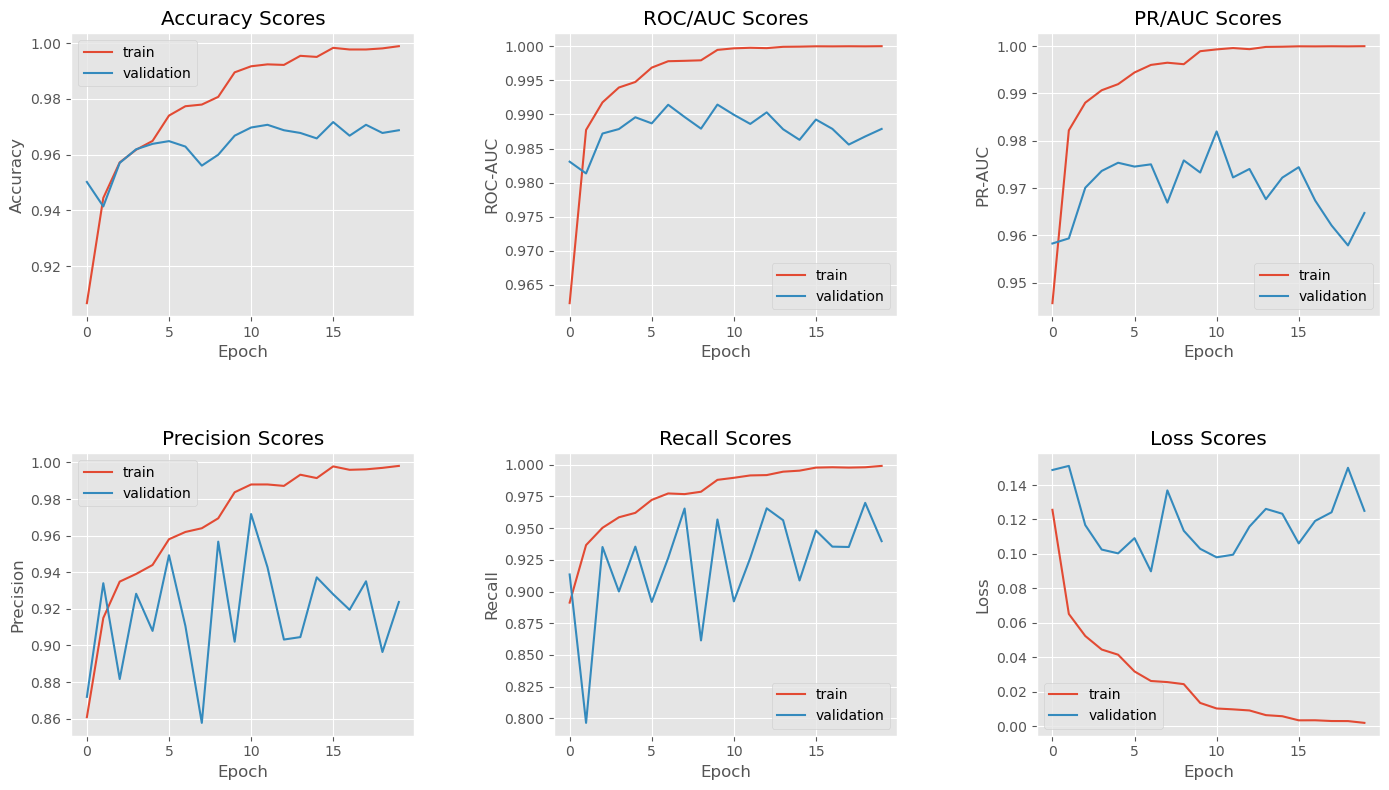

In [11]:
# evaluate model by displaying metrics with visualization
plt.style.use('ggplot')
sixplot2(history, 'auc', 'val_auc', 'auc_1', 'val_auc_1', 'precision', 'val_precision', 'recall', 'val_recall')

In [13]:
score = model.evaluate_generator(generator=valid_generator,
                                 steps=STEP_SIZE_VALID)

print("Validation Loss: " + str(score[0]))
print("Validation Accuracy: " + str(score[1]))
print("Validation Precision: " + str(score[2]))
print("Validation Recall: " + str(score[3]))
print("Validation ROC-AUC: " + str(score[4]))
print("Validation PR-AUC: " + str(score[5]))

Validation Loss: 0.1250956505537033
Validation Accuracy: 0.96875
Validation Precision: 0.9877833724021912
Validation Recall: 0.9642906785011292
Validation ROC-AUC: 0.9230769276618958
Validation PR-AUC: 0.939130425453186


# Testing 

1035/1035 [==============================] - 60s 58ms/step


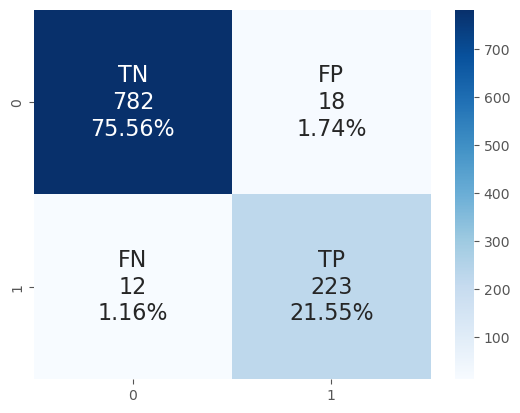

In [23]:
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

# get testing accuracy and loss
test_generator.reset()
# display confusion matrix visualization
pred = model.predict_generator(test_generator, 
                               steps = STEP_SIZE_TEST, 
                               verbose = 1)
y_true = test_generator.classes
y_pred = pred > 0.5
make_confusion_matrix(y_true, y_pred)

In [15]:
predicted_class_indices = np.argmax(pred, axis=1)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]


In [29]:
y_true

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [28]:
labels

{0: 'Non-TB', 1: 'TB'}

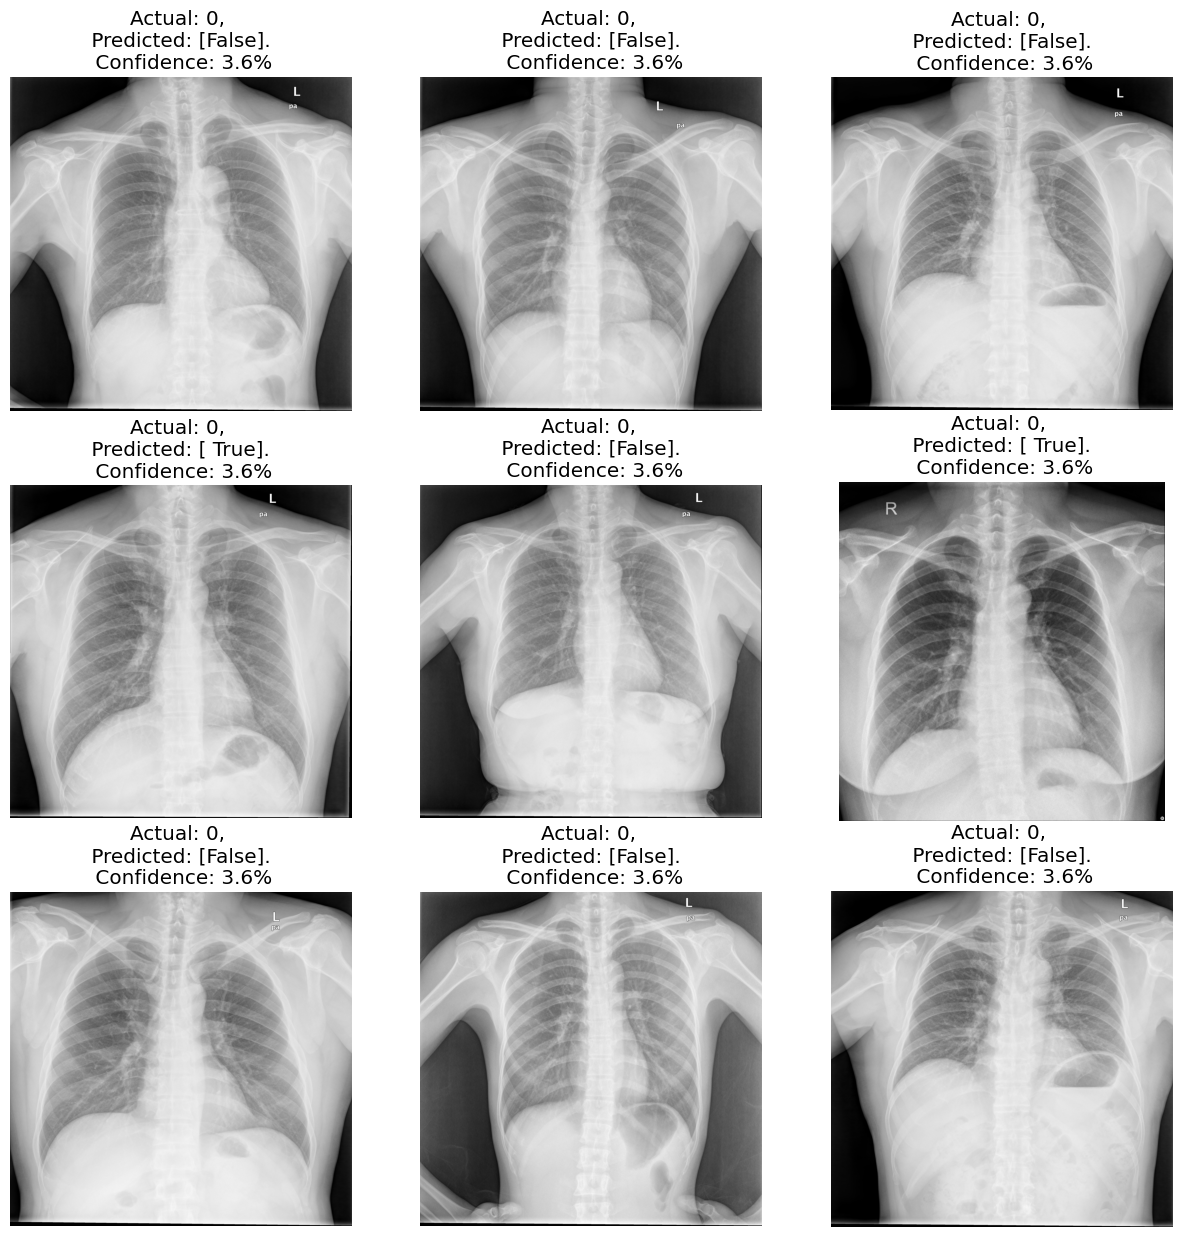

In [32]:
plt.figure(figsize=(15,15))
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    image = plt.imread(os.path.join('../data/augmented_sorted/test', test_generator.filenames[i]))
    plt.imshow(image)

    predicted_class = y_pred[i]
    confidence = round(100 * (np.max(pred[0])),2)
    actual_class = y_true[i]

    plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}. \n Confidence: {confidence}%")
    plt.axis('off')

In [27]:
test_generator.filenames

['Non-TB/CHNCXR_0004_0.png',
 'Non-TB/CHNCXR_0005_0.png',
 'Non-TB/CHNCXR_0014_0.png',
 'Non-TB/CHNCXR_0018_0.png',
 'Non-TB/CHNCXR_0027_0.png',
 'Non-TB/CHNCXR_0030_0.png',
 'Non-TB/CHNCXR_0046_0.png',
 'Non-TB/CHNCXR_0054_0.png',
 'Non-TB/CHNCXR_0059_0.png',
 'Non-TB/CHNCXR_0065_0.png',
 'Non-TB/CHNCXR_0078_0.png',
 'Non-TB/CHNCXR_0081_0.png',
 'Non-TB/CHNCXR_0096_0.png',
 'Non-TB/CHNCXR_0122_0.png',
 'Non-TB/CHNCXR_0161_0.png',
 'Non-TB/CHNCXR_0174_0.png',
 'Non-TB/CHNCXR_0195_0.png',
 'Non-TB/CHNCXR_0202_0.png',
 'Non-TB/CHNCXR_0205_0.png',
 'Non-TB/CHNCXR_0206_0.png',
 'Non-TB/CHNCXR_0219_0.png',
 'Non-TB/CHNCXR_0228_0.png',
 'Non-TB/CHNCXR_0246_0.png',
 'Non-TB/CHNCXR_0259_0.png',
 'Non-TB/CHNCXR_0262_0.png',
 'Non-TB/CHNCXR_0264_0.png',
 'Non-TB/CHNCXR_0297_0.png',
 'Non-TB/CHNCXR_0315_0.png',
 'Non-TB/CHNCXR_0319_0.png',
 'Non-TB/MCUCXR_0001_0.png',
 'Non-TB/MCUCXR_0002_0.png',
 'Non-TB/MCUCXR_0024_0.png',
 'Non-TB/MCUCXR_0044_0.png',
 'Non-TB/MCUCXR_0051_0.png',
 'Non-TB/MCUCX

TypeError: Invalid shape (16, 224, 224, 3) for image data

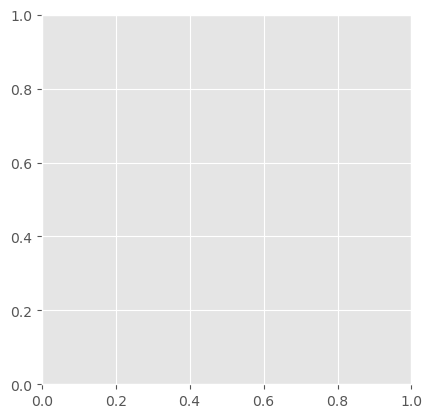

In [25]:
import glob
import cv2

# display sample of melanoma images
plt.style.use('ggplot')
paths = glob('../jpegs/split/train/1_mel/*.jpg')
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(16,6))
plt.suptitle('Melanoma Images', fontsize=16)
for i in range(0, 15):   
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))
    x = i // 5
    y = i % 5
    axes[x, y].imshow(image, cmap=plt.cm.bone)
    axes[x, y].axis('off')


In [19]:
pred

array([[3.6021210e-02],
       [6.3000777e-04],
       [8.3144296e-05],
       ...,
       [9.9936748e-01],
       [1.0000000e+00],
       [9.9897009e-01]], dtype=float32)